In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("./Train_rev1.csv", index_col=None)
print("Data shape:", data.shape)
print(data.head())


Data shape: (244768, 12)
         Id                                              Title  \
0  12612628                        Engineering Systems Analyst   
1  12612830                            Stress Engineer Glasgow   
2  12612844                   Modelling and simulation analyst   
3  12613049  Engineering Systems Analyst / Mathematical Mod...   
4  12613647         Pioneer, Miser Engineering Systems Analyst   

                                     FullDescription  \
0  Engineering Systems Analyst Dorking Surrey Sal...   
1  Stress Engineer Glasgow Salary **** to **** We...   
2  Mathematical Modeller / Simulation Analyst / O...   
3  Engineering Systems Analyst / Mathematical Mod...   
4  Pioneer, Miser  Engineering Systems Analyst Do...   

                         LocationRaw LocationNormalized ContractType  \
0            Dorking, Surrey, Surrey            Dorking          NaN   
1        Glasgow, Scotland, Scotland            Glasgow          NaN   
2  Hampshire, South East,

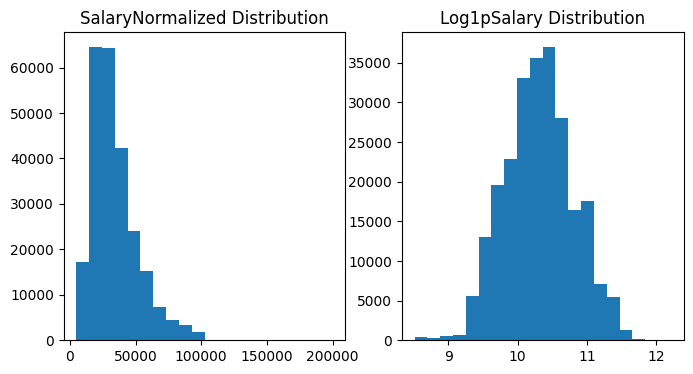

In [2]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)
plt.title('SalaryNormalized Distribution')

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)
plt.title('Log1pSalary Distribution')
plt.show()


In [3]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN')
data[text_columns] = data[text_columns].fillna('')


In [ ]:
import nltk
from nltk.tokenize import WordPunctTokenizer
from collections import Counter

nltk.download('punkt')

tokenizer = WordPunctTokenizer()

def tokenize_text(text):
    tokens = tokenizer.tokenize(text.lower())
    return ' '.join(tokens)

for column in text_columns:
    data[column] = data[column].apply(tokenize_text)


In [5]:
token_counts = Counter()
for text in data[text_columns].values.flatten():
    token_counts.update(text.split())

print("Total unique tokens:", len(token_counts))
print("Most common tokens:", token_counts.most_common(5))


Total unique tokens: 202704
Most common tokens: [('and', 2657388), ('.', 2523216), (',', 2318606), ('the', 2080994), ('to', 2019884)]


In [6]:
min_count = 10
tokens = [token for token, count in token_counts.items() if count >= min_count]

UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens
token_to_id = {token: idx for idx, token in enumerate(tokens)}

print("Vocabulary size:", len(tokens))


Vocabulary size: 34158


In [7]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    if isinstance(sequences[0], str):
        sequences = [seq.split() for seq in sequences]

    max_len = max_len or max(map(len, sequences))
    matrix = np.full((len(sequences), max_len), PAD_IX, dtype=np.int32)

    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix


In [8]:
from sklearn.feature_extraction import DictVectorizer

top_companies = data['Company'].value_counts().nlargest(1000).index
data['Company'] = data['Company'].apply(lambda x: x if x in top_companies else 'Other')

categorical_vectorizer = DictVectorizer(sparse=False)
categorical_vectorizer.fit(data[categorical_columns].to_dict('records'))

print("Number of categorical features:", len(categorical_vectorizer.vocabulary_))


Number of categorical features: 3768


In [9]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.reset_index(drop=True, inplace=True)
data_val.reset_index(drop=True, inplace=True)

print("Training set size:", len(data_train))
print("Validation set size:", len(data_val))


Training set size: 195814
Validation set size: 48954


In [10]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using MPS: {torch.backends.mps.is_available()}")
else:
    device = torch.device('cpu')

def to_tensors(batch, device=device):
    batch_tensors = {}
    for key, arr in batch.items():
        if key in text_columns:
            batch_tensors[key] = torch.tensor(arr, dtype=torch.long, device=device)
        elif key == 'Categorical':
            batch_tensors[key] = torch.tensor(arr, dtype=torch.float32, device=device)
        elif key == TARGET_COLUMN:
            batch_tensors[key] = torch.tensor(arr, dtype=torch.float32, device=device)
    return batch_tensors

def make_batch(data, max_len=100, device=device):
    batch = {
        "Title": as_matrix(data["Title"].values, max_len),
        "FullDescription": as_matrix(data["FullDescription"].values, max_len),
        "Categorical": categorical_vectorizer.transform(data[categorical_columns].to_dict('records')),
    }

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)


Using MPS: True


In [11]:
def load_glove_embeddings(embedding_path, token_to_id, embedding_dim=100):
    embeddings_index = {}
    with open(embedding_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            if word in token_to_id:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors in GloVe.')

    embedding_matrix = np.zeros((len(token_to_id), embedding_dim))
    for word, idx in token_to_id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return embedding_matrix

embedding_dim = 100
embedding_path = 'glove.6B.100d.txt'
embedding_matrix = load_glove_embeddings(embedding_path, token_to_id, embedding_dim)


Found 26223 word vectors in GloVe.


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens, n_cat_features, embedding_matrix, hid_size=64):
        super(SalaryPredictor, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding.from_pretrained(
            embeddings=torch.FloatTensor(embedding_matrix),
            freeze=False  
        )
        
        self.title_conv = nn.Sequential(
            nn.Conv1d(in_channels=self.embedding_dim, out_channels=hid_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        
        self.description_lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=hid_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )
        
        self.attention = nn.Linear(hid_size * 2, 1)
        
        self.categorical_dense = nn.Sequential(
            nn.Linear(n_cat_features, hid_size),
            nn.ReLU()
        )
        
        self.fc = nn.Linear(hid_size * 4, 1)  
        
    def forward(self, batch):
        title_embedded = self.embedding(batch["Title"])  
        desc_embedded = self.embedding(batch["FullDescription"])  
        
        title_embedded = title_embedded.permute(0, 2, 1)  
        title_features = self.title_conv(title_embedded).squeeze(2)  
        
        desc_outputs, _ = self.description_lstm(desc_embedded)  
        
        attn_weights = torch.softmax(self.attention(desc_outputs).squeeze(2), dim=1) 
        desc_features = torch.sum(desc_outputs * attn_weights.unsqueeze(2), dim=1) 
        
        cat_features = self.categorical_dense(batch['Categorical']) 
        
        combined = torch.cat([title_features, desc_features, cat_features], dim=1) 
        
        output = self.fc(combined).squeeze(1) 
        return output


In [21]:
def to_tensors(batch, device=device):
    batch_tensors = {}
    for key, arr in batch.items():
        if key in ["Title", "FullDescription"]:
            batch_tensors[key] = torch.tensor(arr, dtype=torch.long, device=device)
        elif key == 'Categorical':
            batch_tensors[key] = torch.tensor(arr, dtype=torch.float32, device=device)  
        elif key == TARGET_COLUMN:
            batch_tensors[key] = torch.tensor(arr, dtype=torch.float32, device=device)  
    return batch_tensors


def make_batch(data, max_len=100, device=device):
    batch = {
        "Title": as_matrix(data["Title"].values, max_len),
        "FullDescription": as_matrix(data["FullDescription"].values, max_len),
        "Categorical": categorical_vectorizer.transform(data[categorical_columns].to_dict('records')).astype(np.float32),  
    }

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values.astype(np.float32)  

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [22]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

In [13]:
n_tokens = len(tokens)
n_cat_features = len(categorical_vectorizer.vocabulary_)
model = SalaryPredictor(n_tokens, n_cat_features, embedding_matrix, hid_size=64).to(device)

batch = make_batch(data_train[:3], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])

assert dummy_pred.shape == torch.Size([3])
assert len(torch.unique(dummy_pred)) > 1, "Model returns suspiciously few unique outputs. Check your initialization."
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "Make sure you minimize MSE."

print("Model instantiated and tested successfully.")


Model instantiated and tested successfully.


In [29]:
import os
from tqdm import tqdm 

def evaluate(model, data_val, batch_size=256, device=device):
    model.eval()
    mae_loss = 0
    total_samples = 0
    with torch.no_grad():
        for start in range(0, len(data_val), batch_size):
            batch_data = data_val.iloc[start:start+batch_size]
            batch = make_batch(batch_data, device=device)
            preds = model(batch)
            targets = batch[TARGET_COLUMN]
    
            mae_loss += torch.sum(torch.abs(preds - targets)).item()
            total_samples += targets.size(0)
    
        mae = mae_loss / total_samples
    return mae

def train_model(model, data_train, data_val, num_epochs=5, batch_size=256, device=device):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    best_val_mae = float('inf')
    start_epoch = 0
    checkpoint_path = 'salary_predictor_checkpoint.pth'

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_mae = checkpoint['best_val_mae']
        print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0

        with tqdm(total=len(data_train), desc=f'Epoch {epoch+1}/{num_epochs}', unit='sample') as pbar:
            for batch in iterate_minibatches(data_train, batch_size=batch_size, shuffle=True, cycle=False, device=device):
                optimizer.zero_grad()
                preds = model(batch)
                targets = batch[TARGET_COLUMN]
                loss = criterion(preds, targets)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                pbar.update(batch_size)
                pbar.set_postfix({'Training Loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / num_batches
        val_mae = evaluate(model, data_val, batch_size=batch_size, device=device)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_loss:.4f}, Validation MAE: {val_mae:.4f}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_mae': best_val_mae,
        }, checkpoint_path)

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            torch.save(model.state_dict(), 'best_model.pth')

    print("Training complete.")


In [30]:
train_model(model, data_train, data_val, num_epochs=10, batch_size=32, device=device)


Epoch 1/10: 195840sample [02:24, 1352.03sample/s, Training Loss=0.0167]                        


Epoch 1/10, Average Training Loss: 0.0377, Validation MAE: 0.1763


Epoch 2/10: 195840sample [02:29, 1305.66sample/s, Training Loss=0.0672]                        


Epoch 2/10, Average Training Loss: 0.0335, Validation MAE: 0.1842


Epoch 3/10: 195840sample [02:30, 1299.52sample/s, Training Loss=0.0137]                        


Epoch 3/10, Average Training Loss: 0.0299, Validation MAE: 0.1794


Epoch 4/10: 195840sample [02:40, 1220.42sample/s, Training Loss=0.0062]                        


Epoch 4/10, Average Training Loss: 0.0268, Validation MAE: 0.1790


Epoch 5/10: 195840sample [02:31, 1291.60sample/s, Training Loss=0.0213]                        


Epoch 5/10, Average Training Loss: 0.0242, Validation MAE: 0.1747


Epoch 6/10: 195840sample [02:38, 1235.43sample/s, Training Loss=0.0217]                        


Epoch 6/10, Average Training Loss: 0.0218, Validation MAE: 0.1735


Epoch 7/10: 195840sample [05:49, 560.71sample/s, Training Loss=0.0036]                         


Epoch 7/10, Average Training Loss: 0.0199, Validation MAE: 0.1755


Epoch 8/10: 195840sample [07:21, 444.07sample/s, Training Loss=0.0008]                        


Epoch 8/10, Average Training Loss: 0.0183, Validation MAE: 0.1721


Epoch 9/10: 195840sample [06:15, 522.00sample/s, Training Loss=0.0053]                        


Epoch 9/10, Average Training Loss: 0.0169, Validation MAE: 0.1857


Epoch 10/10: 195840sample [06:22, 511.51sample/s, Training Loss=0.0320]                        


Epoch 10/10, Average Training Loss: 0.0156, Validation MAE: 0.1729
Training complete.


In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

val_mae = evaluate(model, data_val, batch_size=32, device=device)
print(f"Final Validation MAE: {val_mae:.2f}")
